In [2]:
import math
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

## Funções

In [3]:
def RegressaoLinear(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    lm = LinearRegression()
    linear = lm.fit(X_train, y_train.ravel())
    print('Score Modelo: {}'.format(linear.score(X_test, y_test)))
    y_pred = lm.predict(X_test)
    print('RMSE (root-mean-squared error): {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))
    
def MatrizCorrelacao(df):
    corr_matrix = df.corr()
    plt.figure(figsize = (15,10))
    sns.heatmap(corr_matrix, cmap="Reds", center=0, annot=True)
    return corr_matrix

def RemoverOutliers(df):
    for column in df.columns:
        data = df[column]

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        minimum = Q1 - (1.5 * IQR)
        maximum = Q3 + (1.5 * IQR)

        outliers = ((data < minimum) | (data > maximum))
        df[column].loc[outliers] = np.nan
        
    return df.dropna()

def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.ylim(0,6000000000)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation MSE')
    plt.subplot(1, 2, 2)
    plt.ylim(0,100000)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Carregando os Dados

In [4]:
df = pd.read_csv("base_exe3.csv");
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  8973 non-null   int64  
 1   margemBrutaAcumulada         8973 non-null   float64
 2   prazoMedioRecebimentoVendas  8973 non-null   int64  
 3   titulosEmAberto              8973 non-null   float64
 4   valorSolicitado              8973 non-null   float64
 5   percentualRisco              8973 non-null   float64
 6   valorAprovado                7569 non-null   float64
 7   ativoCirculante              8973 non-null   float64
 8   passivoCirculante            8973 non-null   float64
 9   totalAtivo                   8973 non-null   float64
 10  totalPatrimonioLiquido       8973 non-null   float64
 11  endividamento                8973 non-null   float64
 12  duplicatasAReceber           8973 non-null   float64
 13  estoque           

Separamos solicitações aprovadas das em Análise

In [10]:
df_analise = df[df.valorAprovado.isnull()]
df_aprovadas = df[~df.valorAprovado.isnull()]

Separando as informações da variável meta e variáveis preditoras

In [12]:
Y = df_aprovadas.valorAprovado
X = df_aprovadas.drop(['valorAprovado'], axis=1)

In [13]:
RegressaoLinear(X, Y)

Score Modelo: 0.17495846112389313
RMSE (root-mean-squared error): 456207.50537551526


Obtemos um RMSE de 456207 e um score baixo de 0.17<br>
Como a Regressão tem um impacto grande com OutLiers iremos eles agora e treinar novamente o modelo

In [14]:
df_sem_Outliers = RemoverOutliers(df_aprovadas)

In [15]:
df_sem_Outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3352 entries, 0 to 8960
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  3352 non-null   float64
 1   margemBrutaAcumulada         3352 non-null   float64
 2   prazoMedioRecebimentoVendas  3352 non-null   float64
 3   titulosEmAberto              3352 non-null   float64
 4   valorSolicitado              3352 non-null   float64
 5   percentualRisco              3352 non-null   float64
 6   valorAprovado                3352 non-null   float64
 7   ativoCirculante              3352 non-null   float64
 8   passivoCirculante            3352 non-null   float64
 9   totalAtivo                   3352 non-null   float64
 10  totalPatrimonioLiquido       3352 non-null   float64
 11  endividamento                3352 non-null   float64
 12  duplicatasAReceber           3352 non-null   float64
 13  estoque           

Separando as informações da variável meta e variáveis preditoras

In [16]:
X = df_sem_Outliers.drop(['valorAprovado'], axis=1)
Y = df_sem_Outliers.valorAprovado

In [17]:
RegressaoLinear(X, Y)

Score Modelo: 0.736276658716232
RMSE (root-mean-squared error): 14297.672250170379


Obtemos um RMSE de 14297 e um score baixo de 0.73<br>

In [55]:
ssc = StandardScaler()
x_ssc = ssc.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(x_ssc, Y, test_size=0.33, random_state=42)

In [56]:
model = Sequential()
model.add(Dense(128, input_dim=19, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               2560      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [57]:
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_regression.hdf5', verbose=1, save_best_only=True, monitor='val_mae')

model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpointer])

Epoch 1/100
51/71 [====================>.........] - ETA: 0s - loss: 32075.7852 - mse: 1912777088.0000 - mae: 32075.7852
Epoch 00001: val_mae improved from inf to 23242.49023, saving model to .\modelo_mlp_regression.hdf5
71/71 [==============================] - 0s 6ms/step - loss: 31156.2266 - mse: 1839353344.0000 - mae: 31156.2266 - val_loss: 23242.4902 - val_mse: 1227766784.0000 - val_mae: 23242.4902
Epoch 2/100
49/71 [===================>..........] - ETA: 0s - loss: 17659.0859 - mse: 750195456.0000 - mae: 17659.0859
Epoch 00002: val_mae improved from 23242.49023 to 12759.30664, saving model to .\modelo_mlp_regression.hdf5
71/71 [==============================] - 0s 3ms/step - loss: 16761.8203 - mse: 672616832.0000 - mae: 16761.8203 - val_loss: 12759.3066 - val_mse: 362725792.0000 - val_mae: 12759.3066
Epoch 3/100
56/71 [======================>.......] - ETA: 0s - loss: 13483.0703 - mse: 439995360.0000 - mae: 13483.0703
Epoch 00003: val_mae improved from 12759.30664 to 11584.46875, 

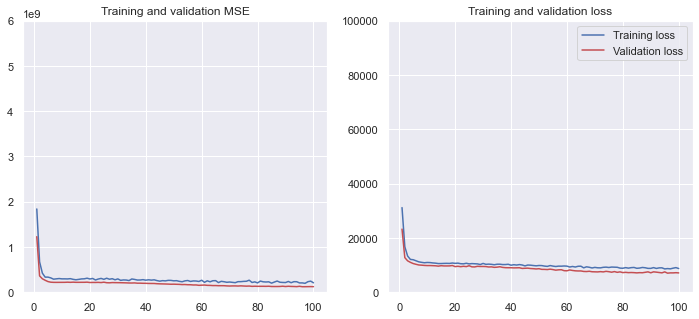

In [58]:
plot_history(history)

In [59]:
model = load_model("./modelo_mlp_regression.hdf5")

In [60]:
y_pred = model.predict(x_test)
y_p_train = model.predict(x_train)

In [61]:
print('RMSE (root-mean-squared error): {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))
print('MAE (mean-absolute error): {}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE (mean-squared error): {}'.format(mean_squared_error(y_test, y_pred)))
print('Variance Score: {}'.format(explained_variance_score(y_test, y_pred)))
print('R2 score: {}'.format(r2_score(y_train, y_p_train)))
print('R2 score: {}'.format(r2_score(y_test, y_pred)))

RMSE (root-mean-squared error): 11111.44333800608
MAE (mean-absolute error): 7042.738980369947
MSE (mean-squared error): 123464173.0537197
Variance Score: 0.8407771629372156
R2 score: 0.8329286214902809
R2 score: 0.8407208803603584


Com a Rede MLP conseguimos um RMSE de 11111

## Prevendo as próximas análises

Vamos usar os Modelos, para prever as solicitações pendentes no momento.

In [62]:
X = df_sem_Outliers.drop(['valorAprovado'], axis=1)
Y = df_sem_Outliers.valorAprovado
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
lm = LinearRegression()
linear = lm.fit(X_train, y_train.ravel())
X_analise = df_analise.drop(['valorAprovado'], axis=1)
Y_analise = lm.predict(X_analise)
Y_analise

array([ 268729.45594942,  313367.75314883,  452938.19351763, ...,
        353472.28954204, 1040320.54890021,  307725.32908316])

In [66]:
x_ssc = ssc.fit_transform(X_analise)

model = load_model("./modelo_mlp_regression.hdf5")
Y_model = model.predict(x_ssc)
Y_model

array([[27222.518],
       [28439.367],
       [29514.896],
       ...,
       [28058.428],
       [31639.201],
       [28158.852]], dtype=float32)